# Requirements

- transformer: hugginface transformers 
- datasets: klue dataset load
- evaluate: 데이터셋 evaluate

In [1]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import

In [4]:
import random
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import TfidfVectorizer # baseline code용 tfidef vectorirzer(또는 tokenizer)
from sklearn import preprocessing
from sklearn.metrics import f1_score
from IPython.display import display, HTML

from transformers import AutoModel, AutoTokenizer,AutoModelForSequenceClassification, TrainingArguments, Trainer # 사용하고자 하는 모델, 토크나이저 적용시 필요
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset, ClassLabel

from tqdm.auto import tqdm # process bar 표시용

import warnings
warnings.filterwarnings(action='ignore') 

In [5]:
pip install Kn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement Kn (from versions: none)
ERROR: No matching distribution found for Kn


In [6]:
# 한글 깨짐 해결방법 : 실행 후 Restart runtime 
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 27 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-san

In [7]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device  # pt 코드에서 필요함

device(type='cuda')

# Data Load

- klue 데이터셋에서 연합뉴스 토픽 분류 라벨링 된 데이터(TC a.k.a ynat)


In [9]:
datasets = load_dataset("klue", "ynat")

Generating train split:   0%|          | 0/45678 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/9107 [00:00<?, ? examples/s]

Dataset klue downloaded and prepared to /root/.cache/huggingface/datasets/klue/ynat/1.0.0/e0fc3bc3de3eb03be2c92d72fd04a60ecc71903f821619cb28ca0e1e29e4233e. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [10]:
# 데이터셋 내에 어떻게 들어있나 보기 위한 함수

# def show_random_elements(dataset, num_examples=10):
#     assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."

#     picks = []
    
#     for _ in range(num_examples):
#         pick = random.randint(0, len(dataset)-1)

#         # 이미 등록된 예제가 뽑힌 경우, 다시 추출
#         while pick in picks:
#             pick = random.randint(0, len(dataset)-1)

#         picks.append(pick)

#     # 임의로 추출된 인덱스들로 구성된 데이터 프레임 선언
#     df = pd.DataFrame(dataset[picks])

#     for column, typ in dataset.features.items():
#         # 라벨 클래스를 스트링으로 변환
#         if isinstance(typ, ClassLabel):
#             df[column] = df[column].transform(lambda i: typ.names[i])

#     display(HTML(df.to_html()))

# show_random_elements(datasets["validation"])    

# Model Load

In [11]:
pretrained_model = 'monologg/kobigbird-bert-base' 
tokenizer = AutoTokenizer.from_pretrained(pretrained_model)

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
# 데이터 tokenize
def preprocess_function(examples):
    return tokenizer(examples["title"], truncation=True,  return_token_type_ids=False,)

tokenized_datasets = datasets.map(preprocess_function, batched=True)


  0%|          | 0/46 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

In [14]:
# loss type define
import evaluate
accuracy = evaluate.load("accuracy")

In [15]:
# 문장을 7개 type으로 분류
# loss(accuracy) 적용
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

id2label = {0: "IT과학", 1: "경제", 2: "사회", 3: "생활문화", 4: "세계", 5:"스포츠", 6: "정치" }
label2id = {"IT과학":0, "경제":1, "사회":2, "생활문화":3, "세계":4, "스포츠":5, "정치":6 }

# model define

- AutoModelForSequenceClassification.from_pretrained : 이용하면 쉽게 모델 정의가능

In [16]:
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model, num_labels=7, id2label=id2label, label2id=label2id)

Some weights of the model checkpoint at monologg/kobigbird-bert-base were not used when initializing BigBirdForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BigBirdForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BigBirdForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BigBirdForSequenceClassific

# Argument set & Run

- 여기서 모델에 쓰이는 parameter정의
- 만들어진 모델은 huggingface에(온라인) 저장한 후 불러올 수 있음
- 불러와서 사용할때 pipline으로 사용 가능

In [17]:
training_args = TrainingArguments(
    output_dir="my_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    # data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

The following columns in the training set don't have a corresponding argument in `BigBirdForSequenceClassification.forward` and have been ignored: title, guid, url, date. If title, guid, url, date are not expected by `BigBirdForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 45678
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2855
  Number of trainable parameters = 114349831
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
Attention type 'block_sparse' is not possible if sequence_length: 21 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_rand

Epoch,Training Loss,Validation Loss,Accuracy
1,0.366300,0.388386,0.869331


The following columns in the evaluation set don't have a corresponding argument in `BigBirdForSequenceClassification.forward` and have been ignored: title, guid, url, date. If title, guid, url, date are not expected by `BigBirdForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 9107
  Batch size = 16
Saving model checkpoint to my_model/checkpoint-2855
Configuration saved in my_model/checkpoint-2855/config.json
Model weights saved in my_model/checkpoint-2855/pytorch_model.bin
tokenizer config file saved in my_model/checkpoint-2855/tokenizer_config.json
Special tokens file saved in my_model/checkpoint-2855/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from my_model/checkpoint-2855 (score: 0.38838616013526917).


TrainOutput(global_step=2855, training_loss=0.45743737429536996, metrics={'train_runtime': 346.6699, 'train_samples_per_second': 131.762, 'train_steps_per_second': 8.236, 'total_flos': 496413595533072.0, 'train_loss': 0.45743737429536996, 'epoch': 1.0})

In [18]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `BigBirdForSequenceClassification.forward` and have been ignored: title, guid, url, date. If title, guid, url, date are not expected by `BigBirdForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 9107
  Batch size = 16


{'eval_loss': 0.38838616013526917,
 'eval_accuracy': 0.8693312836279785,
 'eval_runtime': 14.5679,
 'eval_samples_per_second': 625.14,
 'eval_steps_per_second': 39.127,
 'epoch': 1.0}

In [19]:
trainer.save_model()

Saving model checkpoint to my_model
Configuration saved in my_model/config.json
Model weights saved in my_model/pytorch_model.bin
tokenizer config file saved in my_model/tokenizer_config.json
Special tokens file saved in my_model/special_tokens_map.json


# 문장 하나에 적용

In [20]:
text ='국회, 2월 임시회 개회…6~8일 대정부질문 여야 주자는?'
inputs =  tokenizer(text, truncation=True,  return_token_type_ids=False, return_tensors="pt").to(device)
model.eval()
outputs = model(**inputs)
predictions = outputs.logits.argmax(-1)
id2label[predictions.cpu().numpy()[0]]

'정치'

# 대회 데이터에 적용해보기

In [21]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/과제4/데이터'
mypath = '/content/drive/MyDrive/과제4/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
df = pd.read_csv(path+'/train.csv')

In [23]:
df['분류'] = ''
for i in tqdm(range(len(df))):
  inputs = tokenizer(df["문장"][i], truncation=True,  return_token_type_ids=False,return_tensors="pt").to(device)
  outputs = model(**inputs)
  predictions = outputs.logits.argmax(-1)
  df['분류'][i] = id2label[predictions.cpu().numpy()[0]]

  0%|          | 0/16541 [00:00<?, ?it/s]

In [24]:
df[['문장','분류']]

,문장,분류
0,0.75%포인트 금리 인상은 1994년 이후 28년 만에 처음이다.,경제
1,이어 ＂앞으로 전문가들과 함께 4주 단위로 상황을 재평가할 예정＂이라며 ＂그 이전이...,사회
2,정부가 고유가 대응을 위해 7월부터 연말까지 유류세 인하 폭을 30%에서 37%까지...,경제
3,"서울시는 올해 3월 즉시 견인 유예시간 60분을 제공하겠다고 밝혔지만, 하루 만에 ...",사회
4,익사한 자는 사다리에 태워 거꾸로 놓고 소금으로 코를 막아 가득 채운다.,사회
...,...,...
16536,"＇신동덤＇은 ＇신비한 동물사전＇과 ＇해리 포터＇ 시리즈를 잇는 마법 어드벤처물로, ...",생활문화
16537,"수족냉증은 어릴 때부터 심했으며 관절은 어디 한 곳이 아니고 목, 어깨, 팔꿈치, ...",사회
16538,김금희 소설가는 ＂계약서 조정이 그리 어려운가 작가를 격려한다면서 그런 문구 하나 ...,생활문화
16539,1만명이 넘는 방문자수를 기록한 이번 전시회는 총 77개 작품을 넥슨 사옥을 그대로...,생활문화


['IT과학', '경제', '사회', '생활문화', '세계', '스포츠', '정치']

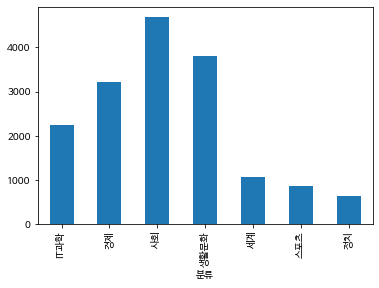

In [25]:
df.groupby('분류').분류.count().plot(kind = 'bar')
list(id2label.values())

In [26]:
df.to_csv(mypath+'_Topic.csv', index=False, encoding = 'euc-kr')